# Исследование рынка общественного питания в Москве

**Цель исследования** 

Исследовать текущий рынок общественного питания в Москве и выявить факторы, влияющие на успех нового бизнеса (небольшое кафе в Москве, где официантами будут роботы).

**Входные данные** 

Из открытых источников доступны данные о заведениях общественного питания в Москве.

**Заказчик исследования**

Потенциальные инвесторы.

**Практическое применение результатов исследования**

Исследование поможет инвесторам в принятии решения об инвестициях в кафе. 

**Описание данных согласно документации:**

* id — идентификатор объекта
* object_name — название объекта общественного питания
* chain — сетевой ресторан
* object_type — тип объекта общественного питания
* address — адрес
* number — количество посадочных мест

<a name='contents'></a>

# Cодержание исследования

## [Шаг 1. Загрузка и подготовка данных к анализу](#stage_1)

* Общая информация о датафрейме
* Поиск дубликатов
* Геолокация объектов (объекты за МКАДом, Новые административные округа Москвы) 

## [Шаг 2. Анализ данных](#stage_2)

* Cоотношение видов объектов общественного питания по количеству
* Соотношение сетевых и несетевых заведений по количеству
* Ответ на вопрос, для какого вида объекта общественного питания характерно сетевое распространение.
* Ответ на вопрос, что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест.
* Выделение названия сетей
* Среднее количество посадочных мест для каждого вида объекта общественного питания. Ответ на вопрос, какой вид предоставляет в среднем самое большое количество посадочных мест.
* Выделение информации об улице в столбец address.
* График топ-10 улиц по количеству объектов общественного питания. Ответ на вопрос, в каких районах Москвы находятся эти улицы.
* Загрузка стороннего файла с улицами Москвы.
* Число улиц с одним объектом общественного питания. Районы Москвы, в которых находятся эти улицы.
* Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.

## [Шаг 3. Общий вывод, рекомендации](#stage_3)

* Вывод
* Рекомендации
* Ссылка на презетацию

**Описание данных согласно документации:**

* id — идентификатор объекта
* object_name — название объекта общественного питания
* chain — сетевой ресторан
* object_type — тип объекта общественного питания
* address — адрес
* number — количество посадочных мест

In [1]:
#Импорт библиотек 

import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from io import BytesIO
import requests
#import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Обновление базовых библиотек для ревьюера. 
#!pip install pandas -U
#!pip install numpy -U
!pip install matplotlib -U
!pip install seaborn -U

     ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/7.3 MB 51.0 kB/s eta 0:01:56^C
     ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/7.3 MB 51.0 kB/s eta 0:01:56
ERROR: Operation cancelled by user
  Using cached seaborn-0.12.1-py3-none-any.whl (288 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


<a name='stage_1'></a>
# Шаг 1. Загрузка и подготовка данных к анализу

[Назад к оглавлению](#contents)

In [3]:
df = pd.read_csv('data/rest_data.csv') 

## Общая информация о датафрейме

In [4]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Сохраним количество записей оригинального датафрейма для проверки.

In [6]:
orig_shape = df.shape[0]

Посмотрим на описательную статистику посадочных мест.

In [7]:
df['number'].describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

Есть общепиты с количеством посадочных мест в 1700 человек. А также такие, где нет мест - 0. 

Проверим, есть ли явные дубликаты.

In [8]:
f'Количество явных дубликатов: {df.duplicated().sum()}'

'Количество явных дубликатов: 0'

## Поиск неявных дубликатов

Сделаем небольшую предобработку текстовых данных:
уберем у столбцов со строковыми данными пробелы слева и справа и больше одного пробела в середине (таковые могут быть) и заменем 'ё' на 'е'.

Для этого создадим функцию.

In [9]:
"""
Функция для предобработки текстовых данных в датафрейме.
Функция берет на вход датафрейм, в цикле перебираются названия столбцов. 
Если столбец не попадает в .describe, то он хранит в себе текстовые данные, а значит, мы можем смело делать преобразования с текстом:
заменяем букву 'ё', в т.ч. большую, на 'е', убираем лишние пробелы в середине и по бокам.
"""
def preprocess_text_columns(dataframe):
    for column_name in dataframe.columns:
        if column_name not in dataframe.describe().columns:
            dataframe[column_name] = (dataframe[column_name].replace({'ё': 'е', 'Ё': 'Е',' {2,}': ' '}, regex=True)
                                   .str.strip())
            

Проверим на тестовом примере, как работает наша функция, прежде чем запускать ее на наших данных.

In [10]:
test = pd.DataFrame({'A': [0, 1, 2, 3],
                   'B': [' весна пришла', 'кафе   Свёкла', 'Ёрш', 'весна ушла ']})

print('Столбец с текстом до предобработки:')
print(test['B'].tolist())
preprocess_text_columns(test)
print('Столбец с текстом ПОСЛЕ предобработки:')
print(test['B'].tolist())

Столбец с текстом до предобработки:
[' весна пришла', 'кафе   Свёкла', 'Ёрш', 'весна ушла ']
Столбец с текстом ПОСЛЕ предобработки:
['весна пришла', 'кафе Свекла', 'Ерш', 'весна ушла']


Предобрабатываем наш исходный датафрейм.

In [11]:
preprocess_text_columns(df)

Посмотрим на айдишники объектов, нет ли там повторяющихся.

In [12]:
df['id'].nunique()

15366

Тут все хорошо. Исследуем дальше. 

Попробуем посмотреть на объекты с одним и тем же адресом, названием, типом объекта и количестом посадочных мест.

In [13]:
df[df.duplicated(subset = ['address', 'object_name', 'object_type', 'number'], keep = False)]

,id,object_name,chain,object_type,address,number
2374,28603,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",100
2381,28611,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",100
2869,25031,LALTRO BOSCO,нет,ресторан,"город Москва, улица Петровка, дом 10",145
3480,20913,Буфет Мади,нет,буфет,"город Москва, Ленинградский проспект, дом 64",40
3481,20914,Буфет Мади,нет,буфет,"город Москва, Ленинградский проспект, дом 64",40
...,...,...,...,...,...,...
14596,204947,Буфет при кинотеатре,нет,буфет,"город Москва, Ореховый бульвар, дом 22А",0
14843,219509,Sushi-Make,нет,предприятие быстрого обслуживания,"город Москва, Ярцевская улица, дом 19",0
14844,219518,Sushi-Make,нет,предприятие быстрого обслуживания,"город Москва, Ярцевская улица, дом 19",0
15173,218542,Кофе с собой,да,предприятие быстрого обслуживания,"город Москва, Алтуфьевское шоссе, дом 70, корп...",0


Уберем параметр keep=False, только первая запись будет считаться уникальной, а все остальные одинаковые будут считаться дубликатами.  

In [14]:
len(df[df.duplicated(subset = ['address', 'object_name', 'object_type', 'number'])])

82

В итоге мы обнаружили 82 дубликата. Посмотрим на них еще раз. 

In [15]:
df[df.duplicated(subset = ['address', 'object_name', 'object_type', 'number'])].head(5)

,id,object_name,chain,object_type,address,number
2381,28611,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",100
3481,20914,Буфет Мади,нет,буфет,"город Москва, Ленинградский проспект, дом 64",40
4431,23759,СТОЛОВАЯ ГБОУ города Москвы № 384,нет,буфет,"город Москва, Беловежская улица, дом 67",100
4537,23391,Столовая «Комбинат питания КОСМОС»,нет,столовая,"город Москва, Новозаводская улица, дом 12/11",15
5059,20021,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, к...",20


Удалим 82 неявных дубликата.

In [16]:
bool_series = df.duplicated(subset = ['address', 'object_name', 'object_type', 'number'])
df = df[~bool_series]

Проверяем, что мы удалили столько дубликатов, сколько нашли.

In [17]:
f"Мы удалили {orig_shape - len(df)} дубликата"

'Мы удалили 82 дубликата'

Отлично, мы удалили ни больше, ни меньше - 82 дубликата. 

Выведем, сколько данных мы отрезали в процентном отношении.

In [18]:
f"Мы отрезали {1 - df.shape[0] / orig_shape:.1%} данных"

'Мы отрезали 0.5% данных'

In [19]:
f'В итоге у нас {len(df)} записей в датафрейме.'

'В итоге у нас 15284 записей в датафрейме.'

Совсем мало и допустимо. Зато данные стали чуть чище. 

Посмотрим на распределение значений по остальным столбцам, кроме id и number.

In [20]:
for column_name in df.columns:
    if column_name not in df.describe().columns:
        print('Столбец:', column_name, '\n')
        print(df[column_name].value_counts(), '\n')

Столбец: object_name 

Столовая                   267
Шаурма                     226
Кафе                       222
KFC                        155
Шоколадница                142
                          ... 
Столовая ТЦ «Энтузиаст»      1
Охунова У.Д.                 1
СОК ООО АВТОКОМБИНАТ 3       1
АВТОКОМБИНАТ 3               1
Кальянная «Мята Lounge»      1
Name: object_name, Length: 10388, dtype: int64 

Столбец: chain 

нет    12320
да      2964
Name: chain, dtype: int64 

Столбец: object_type 

кафе                                 6071
столовая                             2584
ресторан                             2282
предприятие быстрого обслуживания    1898
бар                                   855
буфет                                 577
кафетерий                             395
закусочная                            349
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64 

Столбец: address 

город Москва, Ходынский бульвар, дом 4                        

## Исследование геолокаций объектов: объекты за МКАДом, новые административные округа Москвы

Поскольку изначально речь шла об открытии кафе в Москве, проверим, какие у нас здесь адреса. Вдруг в данных закрались объекты, которые находятся в других городах.

In [21]:
unusual_ad = df[~df['address'].str.contains(r'Москва')]

In [22]:
f'Количество объектов не в пределах МКАД: {len(unusual_ad)}'

'Количество объектов не в пределах МКАД: 71'

Список получился короткий. Посмотрим глазами.

In [23]:
pd.set_option('display.max_rows', None)
unusual_ad['address']

859                             Партизанская улица, дом 30
860                             Партизанская улица, дом 30
1491                  Поречная улица, дом 5/14, строение 1
7691                        1-й Нагатинский проезд, дом 10
7827            Софийская набережная, дом 26/1, строение 1
7938             Нижний Таганский тупик, дом 3, строение 1
8759             Николоямская улица, дом 28/60, строение 1
8760             Николоямская улица, дом 28/60, строение 1
8764           улица Каманина, домовладение 11, строение 2
8771                  Погодинская улица, дом 4, строение 1
8773        Большая Бронная улица, дом 20/1/27, строение 2
8776                2-я Брестская улица, дом 1, строение 1
8793                 Профсоюзная улица, дом 118Б, корпус 1
8798               Калашный переулок, дом 8А/5, строение 3
8803                  Солянский тупик, дом 1/4, строение 1
8804            улица Земляной Вал, дом 58/23, строение 1А
8808                 Таганская площадь, дом 88, строение

In [24]:
pd.reset_option('all', silent=True)

Бросается в глаза город Троицк, поселение Сосенское ит.д. Это новые административные округа Москвы за МКАДом. 
А есть просто московские адреса без указания улиц. Скорее всего, могут быть такие адреса, где есть Москва и при этом город из такого административного округа. Проверим это.

In [25]:
df[df['address'].str.contains(r'Москва,? город')]

,id,object_name,chain,object_type,address,number
1386,22331,СТОЛОВАЯ МИЭТ,нет,столовая,"город Москва, город Зеленоград, улица Юности, ...",56
1405,20199,ЭТО,нет,кафе,"город Москва, город Зеленоград, корпус 401",35
1406,68113,Френдс,нет,кафе,"город Москва, город Зеленоград, корпус 435",34
1407,20105,Кафе «Граф Монте-Кристо»,нет,кафе,"город Москва, город Зеленоград, корпус 436",40
1408,22982,Альфорно,нет,кафе,"город Москва, город Зеленоград, корпус 438",49
...,...,...,...,...,...,...
15206,210732,Баскин Роббинс,да,предприятие быстрого обслуживания,"город Москва, город Московский, улица Хабарова...",0
15244,210743,KFC,да,предприятие быстрого обслуживания,"город Москва, город Московский, улица Хабарова...",0
15256,211215,Милти,да,предприятие быстрого обслуживания,"город Москва, город Щербинка, Железнодорожная ...",0
15327,210815,Милти,да,предприятие быстрого обслуживания,"город Москва, город Московский, улица Хабарова...",0


Точно. Есть и Зеленоград, и Щербинка, и город Московский...

Попробуем в итоге оценить, скольку у нас таких объектов, которые за МКАДом.

In [26]:
za_mkadom = df[df['address'].str.contains(r'(Москва,? город)|поселение|деревня', regex=True)]
za_mkadom

,id,object_name,chain,object_type,address,number
1386,22331,СТОЛОВАЯ МИЭТ,нет,столовая,"город Москва, город Зеленоград, улица Юности, ...",56
1405,20199,ЭТО,нет,кафе,"город Москва, город Зеленоград, корпус 401",35
1406,68113,Френдс,нет,кафе,"город Москва, город Зеленоград, корпус 435",34
1407,20105,Кафе «Граф Монте-Кристо»,нет,кафе,"город Москва, город Зеленоград, корпус 436",40
1408,22982,Альфорно,нет,кафе,"город Москва, город Зеленоград, корпус 438",49
...,...,...,...,...,...,...
15261,211227,Милти,да,предприятие быстрого обслуживания,"город Москва, поселение Внуковское, улица Летч...",0
15309,212713,Burger Club,да,кафе,"город Москва, поселение Воскресенское, Чечерск...",6
15327,210815,Милти,да,предприятие быстрого обслуживания,"город Москва, город Московский, улица Хабарова...",0
15342,210776,Мята Lounge,да,ресторан,"город Москва, город Московский, улица Хабарова...",50


In [27]:
f'Количество объектов общепита за МКАДом: {len(za_mkadom)}'

'Количество объектов общепита за МКАДом: 819'

In [28]:
f'Доля объектов за МКАДом: {za_mkadom.shape[0]/df.shape[0]}'

'Доля объектов за МКАДом: 0.05358544883538341'

5.3 % - это мало. У нас нет уточнений, считать ли новые округа за МКАДом, в данном исследовании. Возможно, это стоит уточнить у заказчика. В рамках данного исследования оставляем все объекты.

### Вывод
    

Первичный анализ данных показал следующее:

* Изначально в данных 15366 записей о 15366 объектах общественного питания.

* Все заявленные в документации параметры (6 столбцов) об объектах общественного питания присутствуют.

* В данных не выявлено пропусков.

* Явных дубликатов не обнаружено, однако были выявлено 82 неявных (0.5 процентов от всех данных), у которых совпадал адрес, тип объекта, количество посадочных мест, название. Такие дубликаты исключены из анализа.
    
* В исходном датафрейме содержалась информация и об объектах общественного питания, которые находятся за МКАДом (города, поселения новых административных округов Москвы, такие как Зеленоград, Щербинка, Московский, Троицк, деревня Дудкино, Сосенское и т.д.). Такие объекты составляют примерно 5.3%. 

* Объекты общественного питания одной и той же сети могут называться по-разному в силу разных причин: к примеру, 'KFC Волгоградский', 'KFC', 'Ресторан KFC', 'Fridays KFC', 'Закусочная KFC', 'Пицца Хат', Pizza Hut, Пицце Хат, PizzaHut.

<a name='stage_2'></a>

# Шаг 2. Анализ данных

[Назад к оглавлению](#contents)

## Cоотношение видов объектов общественного питания по количеству

В качестве самопроверки построим сводную таблицу, в которой для каждого типа будет посчитано количество объектов, к нему принадлежащих.

In [29]:
df.groupby('object_type')['object_type'].agg('count').sort_values(ascending=False)

object_type
кафе                                 6071
столовая                             2584
ресторан                             2282
предприятие быстрого обслуживания    1898
бар                                   855
буфет                                 577
кафетерий                             395
закусочная                            349
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

Построим столбчатую диаграмму c помощью библиотеки seaborn, показывающую распределение объектов общественного питания по типу в процентном отношении

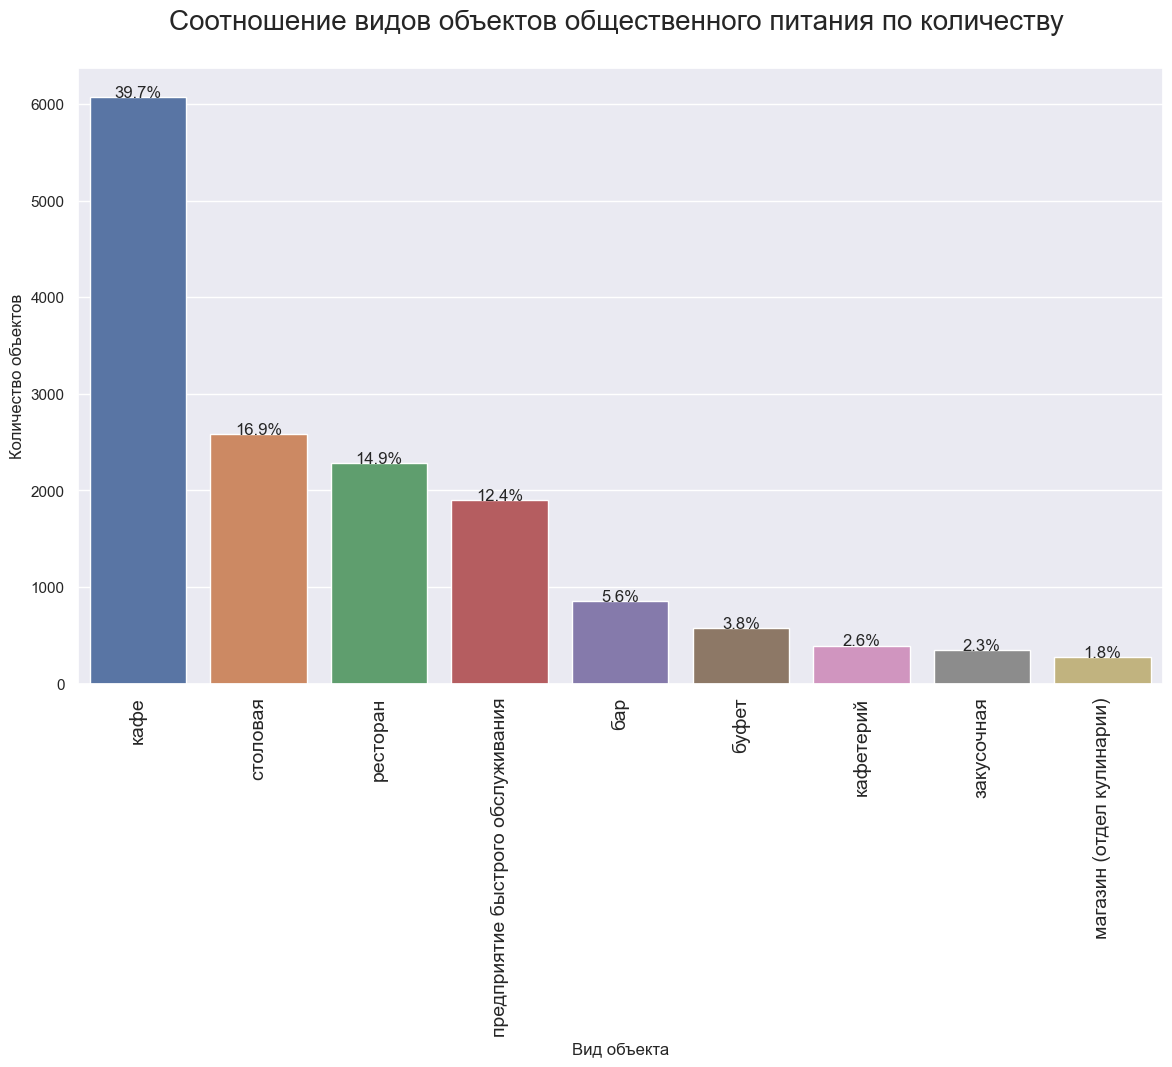

In [30]:
total = float(df.shape[0])
plt.figure(figsize=(14,8))
sns.set_palette('muted')
sns.set_theme(style="darkgrid")
ax = (sns.countplot(x='object_type', data=df, order=df.groupby('object_type')
                    .size().sort_values().index[::-1]))

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.title('Cоотношение видов объектов общественного питания по количеству \n',fontsize=20)
plt.xlabel('Вид объекта')
plt.ylabel('Количество объектов')
plt.xticks(fontsize=14, rotation=90)
plt.show();

### Вывод

Из графика хорошо видно, что больше всего в Москве кафе (39.7%), столовых (16.9%) и ресторанов (14.9%). 

## Соотношение сетевых и несетевых заведений по количеству

Для начала просто посмотрим в цифрах:

In [31]:
df.groupby('chain')['chain'].count()

chain
да      2964
нет    12320
Name: chain, dtype: int64

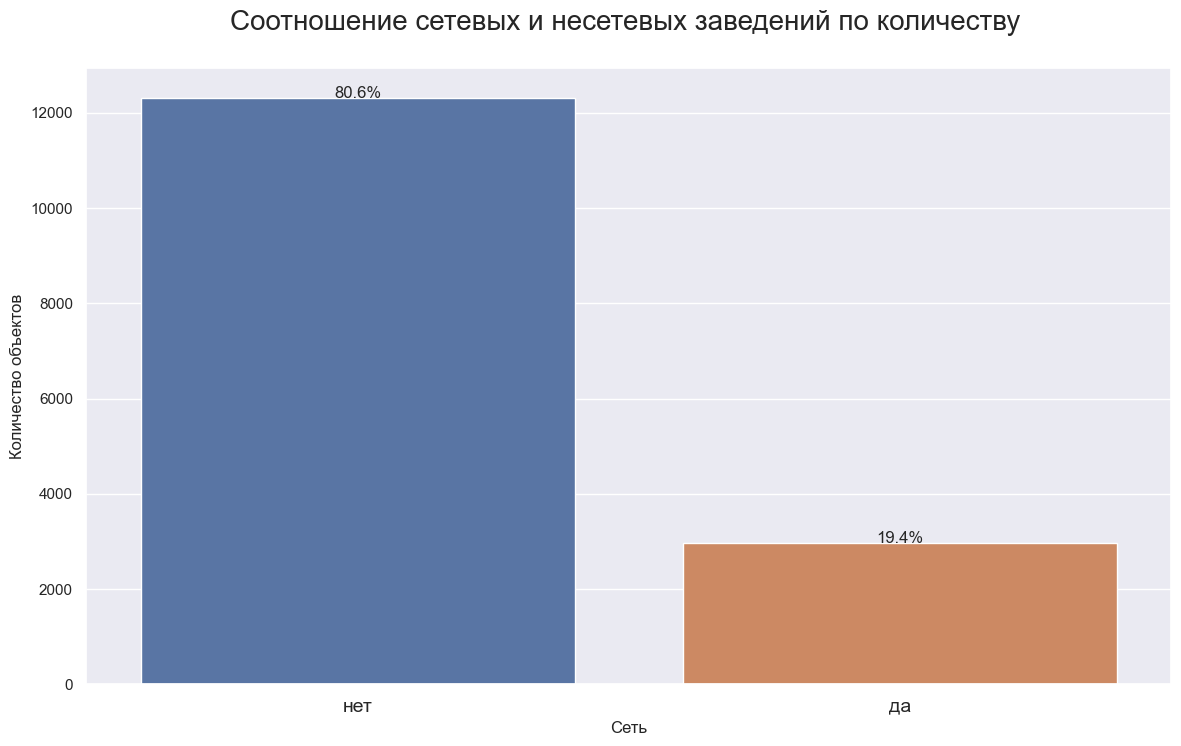

In [32]:
total = float(df.shape[0])
plt.figure(figsize=(14,8))
sns.set_palette('muted')
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='chain', data=df, order=df.groupby('chain').size().sort_values().index[::-1])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.title('Соотношение сетевых и несетевых заведений по количеству \n',fontsize=20)
plt.xlabel('Сеть')
plt.ylabel('Количество объектов')
plt.xticks(fontsize=14)
plt.show();

### Вывод

По сырым данным на московском рынке общественного питания только `19.5%` объектов являются `сетевыми`, 
`80.5%` объектов `не принадлежат ни к какой сети`.

## Для какого вида объекта общественного питания характерно сетевое распространение

Сделаем сводную таблицу, сгруппировав данные по виду объекта и посчитав, сколько в каждом виде объектов.

In [33]:
piv_ch = (df.pivot_table(index=['object_type'], columns='chain', values='id', aggfunc='count')
          .reset_index()
         )

In [34]:
piv_ch.head()

chain,object_type,да,нет
0,бар,37,818
1,буфет,11,566
2,закусочная,56,293
3,кафе,1396,4675
4,кафетерий,52,343


Добавим проценты: узнаем, какой процент составляют сетевые объекты от общего количества объектов для каждого вида. 

In [35]:
piv_ch['precentage_of_chain_objects'] = (piv_ch['да']/(piv_ch['да']+piv_ch['нет'])*100)
(piv_ch.sort_values(by='precentage_of_chain_objects', ascending=False)
 .style
 .format({'precentage_of_chain_objects': '{:.1f}'})
 .highlight_max(color='yellowgreen', subset=['precentage_of_chain_objects'])
)

chain,object_type,да,нет,precentage_of_chain_objects
6,предприятие быстрого обслуживания,788,1110,41.5
5,магазин (отдел кулинарии),78,195,28.6
7,ресторан,543,1739,23.8
3,кафе,1396,4675,23.0
2,закусочная,56,293,16.0
4,кафетерий,52,343,13.2
0,бар,37,818,4.3
1,буфет,11,566,1.9
8,столовая,3,2581,0.1


### Вывод

Более всего `сетевое` распространение характерно для `предприятия быстрого обслуживания` - `41.5%` от всех данных.

## Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест.

Для ответа на этот вопрос нам потребуется знать имя сети для каждого сетевого объъекта.
Попробуем выделить в отдельную категорию имя сети.

Прежде посмотрим на список объектов с одинаковым именем, при этом разным значением в параметре chain. 

In [36]:
chain = df.query('chain == "да"')['object_name']

In [37]:
not_chain = df.query('chain == "нет"')['object_name']

In [38]:
intersected_obj_name = np.intersect1d(chain, not_chain)

Вот список пересечений списков сетевых и несетевых объектов с одинаковым именем.

In [39]:
intersected_obj_name

array(['FRIDAYS', 'Goodman Гудман', 'Tutti frutti', 'UPSIDE DOWN CAKE',
       'Upside Down Cake', 'Азбука Вкуса', 'Азбука вкуса', 'Виктория',
       'Готовые блюда Милти', 'Кальянная Мята Lounge', 'Кафе «Subway»',
       'Кафе «Хинкальная»', 'Кафе «Шоколадница»', 'Кафе «Штолле»',
       'Кафе при АЗС', 'Колбасофф', 'Кондитерская-пекарня Волконский',
       'Кофе', 'Лукойл', 'Мята', 'Пицца «Паоло»', 'Ресторан «KFC»',
       'Ресторан «Бургер Кинг»', 'Ресторан «Ерш»',
       'Ресторан «Хинкальная»', 'Ресторан «Якитория»', 'Темпл Бар',
       'Теремок-Инвест', 'Шоколадница', 'Япоша'], dtype=object)

Да, похоже, не все данные достоверные по части параметра chain. Бургег Кинг, Fridays, KFC, Якитория итд - это все сетевые рестораны, а мы видим, что они попали и в категорию несетевых в этих данных. 

Тогда мы не будем делать срез по chain == 'да', а попробуем поискать ключевые подстроки для названий сети по всем строкам датафрейма.

В начале посмотрим на самые частотные названия заведений. 
Поскольку нас интересуют сетевые, а параметру chain мы не особо хотим доверять, попробуем поставить ограничение на количество объектов с одинаковым именем (должно быть два или больше). Этот список используем для того, чтобы обработать самые частотные сети, представленные в этом датасете.

In [40]:
df['object_name'].value_counts().loc[lambda x : x>=2]

Столовая                  267
Шаурма                    226
Кафе                      222
KFC                       155
Шоколадница               142
                         ... 
Кафе «Крошка Картошка»      2
Виктория                    2
Мисада                      2
Райская Трапеза             2
Лига Пап                    2
Name: object_name, Length: 1033, dtype: int64

Создадим список со всеми названиями, отсортированный в алфавитном порядке. Чтобы было удобно на нем отлаживать нашу функцию.

In [41]:
all_names = sorted(df['object_name'].tolist())
all_names[:10]

['1-ЫЙ МОСКОВСКИЙ КАДЕТСКИЙ КОРПУС',
 '1-й МОК',
 '100 личная столовая',
 '100 личное кафе',
 '1001 ночь',
 '100лоФФка',
 '101 вкус',
 '13 RULES',
 '13 RULES KRAFT BEER',
 '13 Rules']

Опираясь на оба эти списка обработаем названия для крупных сетей.

### Выделение названий сетей в отдельный столбец

Напишем функцию, которая будет возвращать имя сети или unknown в случае, когда имя сети не определяется.

Для объектов, где сразу два ресторана типа "Вlack Burger Чайхона №1" будет возвращаться первое сработавшее условие. То есть тут будет огрубление. Но это нам не так важно для ответа на поставленный вопрос.

In [42]:
"""
Функция берет на вход строку и возвращает строку с именем сети или unknown согласно паттернам регулярного выражения.

"""
def get_name_for_chain(string):
    if re.search(r'KFC|кф[cс]', string, re.IGNORECASE):
        return 'KFC'
    elif re.search (r'Шоколадниц', string, re.IGNORECASE):
        return 'Шоколадница'
    elif re.search (r'Бургер ?Кинг|Burger ?King', string, re.IGNORECASE):
        return 'Burger King'
    elif re.search (r'Макдональ?дс|Mc ?Donal', string, re.IGNORECASE):
        return 'McDonalds'
    elif re.search (r"Домино'?с|Domino[,'-]?s", string, re.IGNORECASE):
        return "Domino's Pizza"
    elif re.search (r'(?<!восточный )Теремок', string, re.IGNORECASE): #чтобы не цеплять "Восточный теремок"
        return 'Теремок'
    elif re.search (r'Крошка[ -]?Картошка', string, re.IGNORECASE):
        return 'Крошка Картошка'
    elif re.search (r'Милти|Mealty', string, re.IGNORECASE):
        return 'Милти'
    elif re.search (r'Суши ?[WВ][oо][kк]', string, re.IGNORECASE):
        return 'Суши Wok'
    elif re.search (r'Папа ?Джонс|Papa ?John’?s', string, re.IGNORECASE):
        return 'Papa John’s'
    #Иногда это как вид объекта, поэтому чтобы исключить 'Кофе с собой "Coffee Way"' и подобное
    elif re.fullmatch (r'Кофе с собой', string, re.IGNORECASE): 
        return 'Кофе с собой'
    elif re.search (r'Чайх[оа]на ?№?1|Chaihona ?№?1', string, re.IGNORECASE):
        return 'Чайхона №1'
    elif re.search (r'Кофе[ -]?Хау[сз]', string, re.IGNORECASE):
        return 'Кофе Хауз'
    elif re.search (r'Старба[кг][сз]|Starbucks', string, re.IGNORECASE):
        return 'Starbucks'
    elif re.search (r'Додо ?Пицца|Do Do Пиц', string, re.IGNORECASE):
        return 'Додо Пицца'
    elif  re.search (r'Якитория', string, re.IGNORECASE):
        return 'Якитория'
    elif  re.search (r'Subway|Саб ?вей', string, re.IGNORECASE):
        return 'Subway'
    elif  re.search (r'Донер ?Кебаб|Doner Keb', string, re.IGNORECASE):
        return 'Донер Кебаб'
    elif  re.search (r'Тануки', string, re.IGNORECASE):
        return 'Тануки'
    elif  re.search (r'Хлеб ?насущный', string, re.IGNORECASE):
        return 'Хлеб Насущный'   
    elif  re.search (r'(Иль|Il)[ -]?Патио', string, re.IGNORECASE):
        return 'Il Патио'     
    if  re.search (r'(Прайм|Prime) ?(стар|star)', string, re.IGNORECASE):
        return 'Prime' 
    #Та же сеть, что и выше. Чтобы не цеплять Prime Beef, Prime Mart
    elif re.fullmatch (r'Прайм|Prime|Prime Cafe|Кафе Prime|Прайм-кафе|Deli by Prime Прайм-кафе', string, re.IGNORECASE):
        return 'Prime' 
    elif  re.search (r'(Osteria|Остерио) ?(Mario|Марио)', string, re.IGNORECASE):
        return 'Osterio Mario'
    elif re.search (r'Вьет ?кафе|VietCafe', string, re.IGNORECASE):
        return 'Вьеткафе'
    elif re.search (r'Cofix', string, re.IGNORECASE):
        return 'Cofix'
    elif re.search (r'Мята ?(Lounge|Лаундж)', string, re.IGNORECASE):
        return 'Мята Lounge'
    elif re.search (r'Пицц?[ае] ?Хат|Pizz?a Hut', string, re.IGNORECASE): #Пице Хат
        return 'Pizza Hut'
    elif re.search (r'(Суши|Sushi) ?(Шоп|Shop)', string, re.IGNORECASE): 
        return 'Сушишоп' 
    elif re.search (r'Суши ?стор', string, re.IGNORECASE): 
        return 'СушиСтор'  
    elif re.search (r'Караваевы', string, re.IGNORECASE): 
        return 'Кулинарная лавка братьев Караваевых'  
    elif re.search (r'Му[ -]Му', string, re.IGNORECASE): 
        return 'Му-му'   
    elif re.search (r'Урюк', string, re.IGNORECASE): 
        return 'Урюк'  
    elif re.search (r'Алл?о ?Пицц?а', string, re.IGNORECASE): 
        return 'Алло Пицца'  
    elif re.search (r'Кофемания', string, re.IGNORECASE): 
        return 'Кофемания'
    elif re.search (r'Штолле', string, re.IGNORECASE): 
        return 'Штолле'   
    elif re.search (r'Волконск', string, re.IGNORECASE): 
        return 'Волконский' 
    elif re.search (r'Стардог!?[Sс]?|Stardogs', string, re.IGNORECASE): 
        return 'Стардогс'     
    elif re.search (r'Андерсо?н', string, re.IGNORECASE): 
        return 'кафе АндерСон'
    elif re.search (r'Азбука ?Вкуса', string, re.IGNORECASE): 
        return 'Азбука Вкуса'  
    elif re.search (r'То ?Да ?Се', string, re.IGNORECASE): 
        return 'ТоДаСё'       
    elif re.search (r'Джон ?Джоли', string, re.IGNORECASE): 
        return 'Джонджоли'     
    elif re.search (r'Баскин ?Робб?инс|Baskin', string, re.IGNORECASE): 
        return 'Баскин Роббинс'       
    elif re.search (r'Пицц?[ае] ?Паоло', string, re.IGNORECASE): 
        return 'Пицца Паоло'     
    elif re.search (r'Кружка(?! и)', string, re.IGNORECASE): #Бутылка, Кружка и котел
        return 'Кружка'
    elif re.search (r'Грабли', string, re.IGNORECASE):
        return 'Грабли'
    elif re.search (r'Суши ?Сет', string, re.IGNORECASE): 
        return 'Cушисет'   
    elif re.search (r'Ваби[- ]?Саби', string, re.IGNORECASE): 
        return 'Ваби-Саби'     
    elif re.search (r'Вареничная ?№?1', string, re.IGNORECASE): 
        return 'Вареничная №1'
    elif re.search (r'(?<!Штопор и )Дабл ?би', string, re.IGNORECASE): #Кафе «Пробка и Штопор и Даблби»
        return 'Даблби'
    elif re.search (r'Cinnabon?', string, re.IGNORECASE): #CINNABO
        return 'Cinnabon'
    elif re.search (r'Брусника', string, re.IGNORECASE): 
         return 'Брусника'    
    elif re.search (r'Тирольские пироги', string, re.IGNORECASE): 
        return 'Тирольские пироги'
    elif re.search (r'КОЛБАСОФФ', string, re.IGNORECASE): 
        return 'Колбасофф'
    elif re.search (r'Нияма', string, re.IGNORECASE): 
         return 'Нияма'
    elif re.search (r'Тарас Бульба', string, re.IGNORECASE): 
        return 'Тарас Бульба'
    elif re.search (r"D[uo]nkin'? Donuts|Данкин ?Донатс", string, re.IGNORECASE): 
        return 'Dunkin Donuts'
    elif re.search (r'сварня', string, re.IGNORECASE): 
         return 'Сварня'
    elif re.search (r'[KC]rispy [KC]reme?', string, re.IGNORECASE): #Krispy Krem
         return 'Krispy Kreme'
    elif re.search (r'гурман[»"]?\b', string, re.IGNORECASE): #чтоб не цеплять Ресторан «Очаг гурманов» или Гурмания
         return 'Гурман'
    elif re.search (r'руккола', string, re.IGNORECASE): 
         return 'Руккола'
    elif re.search (r'гудман\b|goodman', string, re.IGNORECASE): #Гудман Гудвин
        return 'Goodman'
    #с Хинкальными черт ногу сломит. 
    #Всего 81 штука в датасете. И неясно, какой объект, к какой сети можно относить.
    #Выделяю отдельно только то, что более и менее определенно
    elif re.fullmatch (r'Хинкальная ?№?1', string, re.IGNORECASE): 
        return 'Хинкальная №1'
    elif re.search (r'кофе[ -]?бин|coffee bean', string, re.IGNORECASE): 
         return 'Coffee Bean'
    elif re.search (r'Jeffreys coffee', string, re.IGNORECASE): 
         return 'Jeffreys coffee'
    elif re.search (r'Хлеб&Co|Хлеб и Co', string, re.IGNORECASE): 
         return 'Хлеб&Co'
    elif re.search (r'Воккер', string, re.IGNORECASE): 
         return 'Воккер'
    elif re.search (r'Пиццетория', string, re.IGNORECASE): 
         return 'Пиццетория'
    elif re.search (r'Две палочки', string, re.IGNORECASE): 
         return 'Две палочки'
    elif re.search (r'Французская выпечка', string, re.IGNORECASE): 
         return 'Французская выпечка'
    elif re.search (r'Джаганнат', string, re.IGNORECASE): 
         return 'Джаганнат'
    elif re.search (r'ПРАВDА|Правда кофе', string, re.IGNORECASE): 
         return 'Правда кофе'
    elif re.search (r'Чебуречная СССР', string, re.IGNORECASE): 
         return 'Чебуречная СССР'  
    elif re.search (r'Гамбринус', string, re.IGNORECASE): 
         return 'Гамбринус'
    elif re.search (r'Московская сеть кальянных', string, re.IGNORECASE): 
         return 'МСК Московская сеть кальянных'
    elif re.search (r'BB[& энд]?Burgers?|BB энд Burger', string, re.IGNORECASE): 
         return 'BBBurgers'
    elif re.search (r'Black star burger', string, re.IGNORECASE): 
         return 'Black Star Burger'
    else:
        return 'unknown'     

Ячейка для теста отдельных условий функции

In [43]:
def test(string):
    if re.search (r'BB[& энд]?Burgers?|BB энд Burger', string, re.IGNORECASE): 
        print(string)

Ячейка для проверки отдельных регулярных выражений в датафрейме.

In [44]:
df[df.object_name.str.contains('кофе[ -]?бин|coffee bean',case=False,regex=True)]

,id,object_name,chain,object_type,address,number
390,88745,Кофе Бин,нет,кафе,"город Москва, Долгоруковская улица, дом 39/6",35
554,25606,Кофе-Бин,да,кафе,"город Москва, Ленинградский проспект, дом 56",41
759,129861,Кафе «Coffee Bean»,нет,кафе,"город Москва, Брюсов переулок, дом 2/14, строе...",56
1245,125335,Кофейня кофе Бин,нет,кафе,"город Москва, улица Хачатуряна, дом 16",45
1302,21813,Кофе-Бин,да,кафе,"город Москва, улица Покровка, дом 21-23/25, ст...",47
3234,22460,Кофе-Бин,да,кафе,"город Москва, улица Сретенка, дом 22/1, строен...",35
4244,69846,КОФЕ БИН,нет,кафе,"город Москва, Сельскохозяйственная улица, дом ...",20
9357,167073,Кафе «Кофе бин»,нет,кафе,"город Москва, Пресненская набережная, дом 6, с...",60


Применим функцию к столбцу с названиями и создадим столбец с названием сети chain_name.

In [45]:
df['chain_name'] = df['object_name'].apply(get_name_for_chain)

Посмотрим, как отработала функция.

In [46]:
pd.set_option('display.max_rows', None)
df['chain_name'].value_counts()

unknown                                12577
KFC                                      192
Шоколадница                              189
McDonalds                                173
Burger King                              162
Теремок                                  115
Domino's Pizza                           111
Крошка Картошка                           99
Суши Wok                                  96
Милти                                     85
Starbucks                                 72
Prime                                     68
Papa John’s                               68
Subway                                    59
Додо Пицца                                56
Донер Кебаб                               55
Чайхона №1                                52
Якитория                                  51
Il Патио                                  50
Тануки                                    47
Кофе Хауз                                 44
Кофе с собой                              44
Мята Loung

Количество объектов по крупным сетям прибавилось. Теперь Шоколадница по количеству объектов обогнала KFC.
Неизвестных сетей у нас стало больше (11881), чем объектов, имеющих значение "нет" в параметре chain (11642), с другой стороны данные по крупным сетям стали чистыми.

Посмотрим, какие сети мы не обработали.

In [47]:
chains_not_in_analysis = df.query('chain_name=="unknown" and chain=="да"')['object_name'].value_counts().to_dict()

In [48]:
chains_not_in_analysis.items()

dict_items([('Хинкальная', 35), ('Пицца Экспресс', 7), ('Сити Пицца', 6), ('Менза', 5), ('Жан Жак', 5), ('Мимино', 5), ('Costa Coffee', 5), ('MosKalyan', 5), ('Wok & Box', 5), ('Пицца Фабрика', 5), ('Ташир пицца', 5), ('Шантимель', 5), ('Панчо Пицца', 5), ('Ливан-хаус', 5), ('Бургер клаб', 4), ('Coffeeshop Company', 4), ('Территория', 4), ('Магбургер', 4), ('Ерш', 4), ('Кебаб Хаус', 4), ('АКАДЕМИЯ', 4), ('СушиМан', 3), ('Маки-Маки', 3), ('Bocconcino', 3), ('Рецептор', 3), ('Travelers Coffee', 3), ('Золотая вобла', 3), ('Кафе «Хинкальная»', 3), ('Burger Club', 3), ('Космик', 3), ('Ичибан Боши', 3), ('Ресторан «Планета Суши»', 3), ('ХИНКАЛЬНАЯ', 3), ('Да Пино', 3), ('Блинная', 3), ('Sushilka', 3), ('Лепешка', 3), ('Пронто', 3), ('Поль Бейкери', 3), ('GlowSubs Sandwiches', 3), ('Де Марко', 3), ('Порто Мальтезе', 3), ('Суп Кафе', 2), ('Дорогая я перезвоню', 2), ('Изба', 2), ('Бакинский бульвар', 2), ('Хачапури', 2), ('Квартира 44', 2), ('Мистер Картошка', 2), ('ПИЛЗНЕР', 2), ('Зодиак', 2),

Все крупные сети обработаны успешно. Можно продолжать анализ.

Создадим срез по выделенным нами сетям, посчитаем для каждой сети среднее количество посадочных мест и количество объектов этой сети.

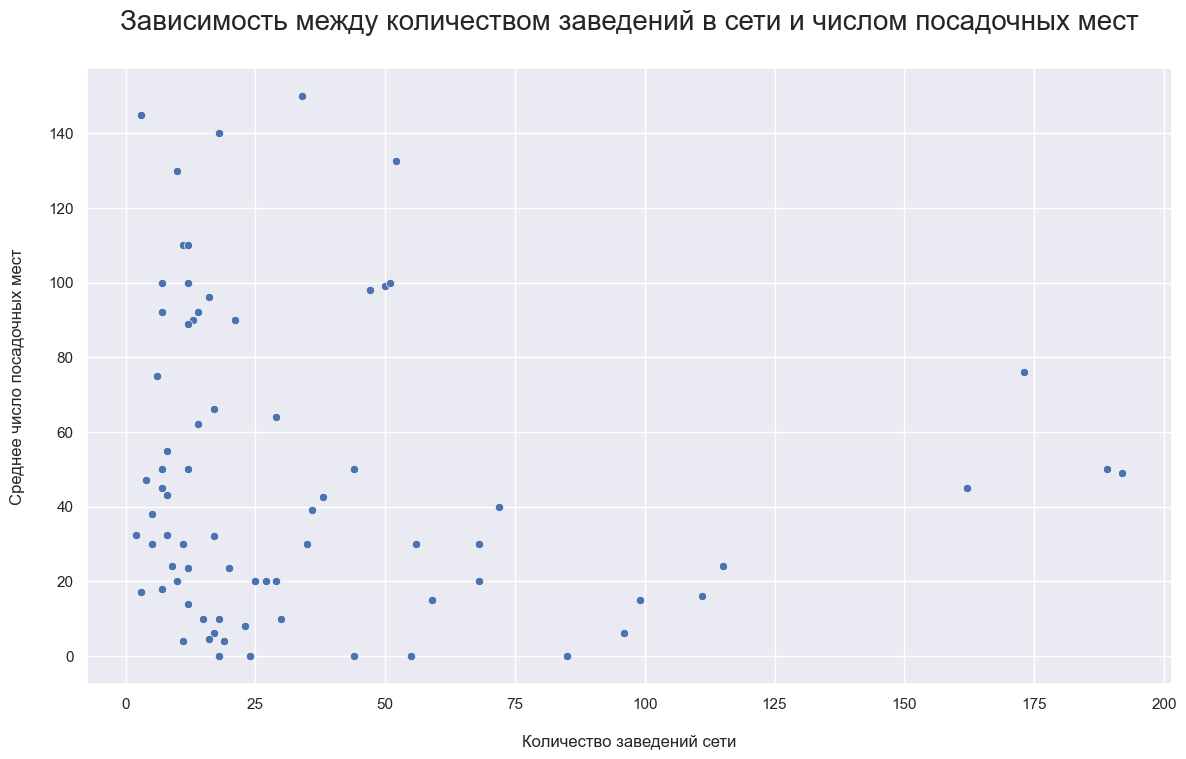

In [49]:
chain_obj_number = df.query('chain_name != "unknown"').groupby('chain_name').agg({'id':'count','number': 'median'})

plt.figure(figsize=(14,8))
sns.set_palette('muted')
sns.set_theme(style="darkgrid")
sns.scatterplot(x='id', y='number', data=chain_obj_number)
plt.title('Зависимость между количеством заведений в сети и числом посадочных мест\n',fontsize=20)
plt.xlabel('\nКоличество заведений сети')
plt.ylabel('Среднее число посадочных мест\n')
plt.show();

### Вывод

На графике видно, что большая часть точек, которые наверху, сосредоточены в интервале от 0 до 25.

Для большей части сетей характерно малое количество заведений с большим количеством посадочных мест.

## Cреднее количество посадочных мест для каждого вида объекта общественного питания. Какой вид предоставляет в среднем самое большое количество посадочных мест.

In [50]:
type_number = df.groupby('object_type')['number'].agg(['mean']).sort_values(by='mean', ascending=False)
(type_number
 .style
 .format("{:.0f}")
 .background_gradient(cmap='Blues', axis=0)
)

,mean
object_type,
столовая,130
ресторан,97
буфет,52
бар,44
кафе,40
предприятие быстрого обслуживания,21
кафетерий,9
закусочная,8
магазин (отдел кулинарии),6


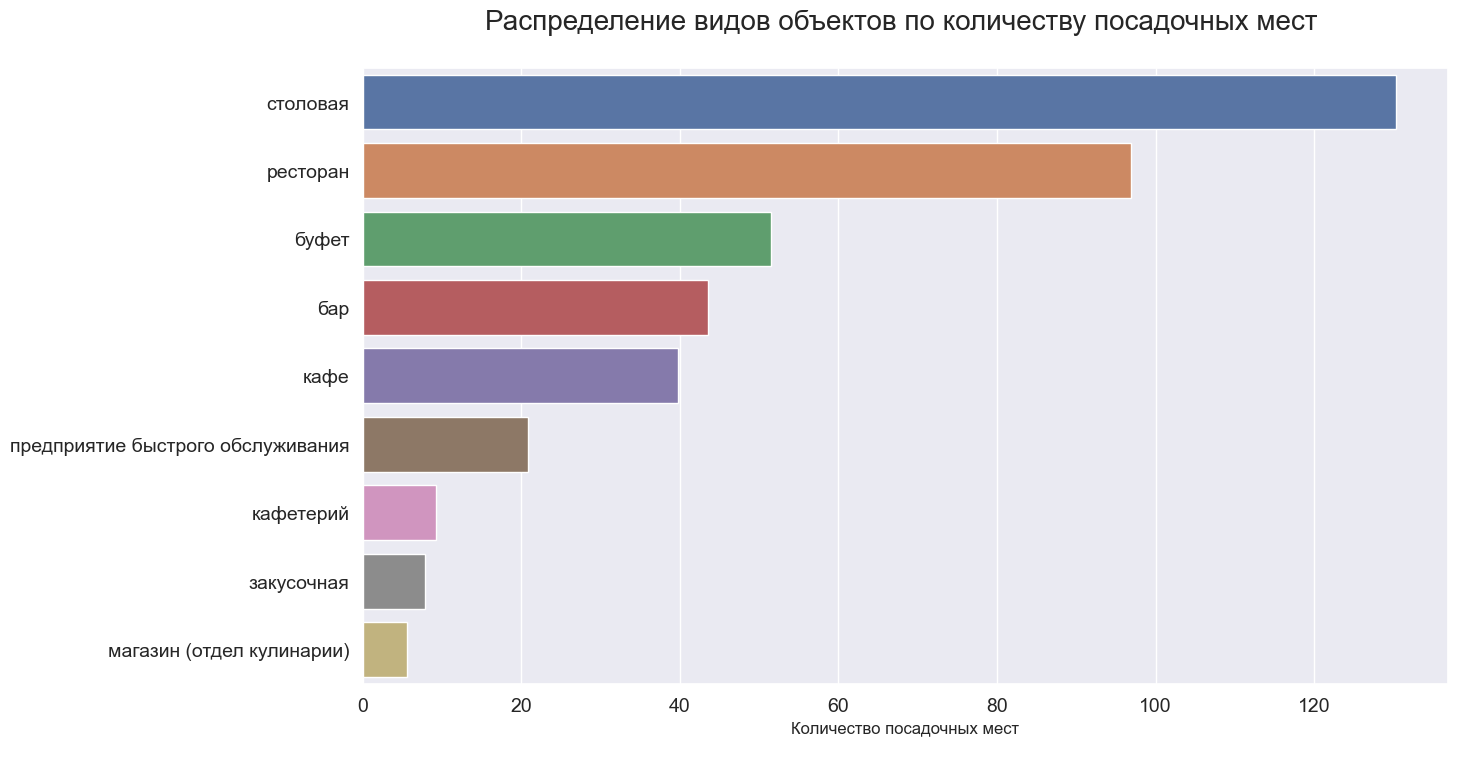

In [51]:
plt.figure(figsize=(14,8))
sns.set_palette('pastel')
sns.set_theme(style="darkgrid")
sns.barplot(x='mean', y='object_type', orient='h', data=type_number.reset_index())
plt.title('Распределение видов объектов по количеству посадочных мест \n',fontsize=20)
plt.ylabel('')
plt.yticks(fontsize=14)
plt.xlabel('Количество посадочных мест\n')
plt.xticks(fontsize=14)
plt.show();

### Вывод

И из графика, и из таблицы (тут данных немного и хорошо все видно) можем сказать, что в среднем самое большое количество посадочных мест имеют столовые. Логично. 

Скорее всего, столовые для данного бизнеса не будут интересны, поэтому отметим, что рестораны в среднем имеет наибольшее число посадочных мест после столовой.

## Выделение информации об улице в столбец address 

Вытащим все адреса из датафрейма в список. С помощью списка найдем все возможные маркеры-ключевые слова для названия улицы.

In [52]:
address_lst = df['address'].tolist()
address_lst[:5]

['город Москва, улица Егора Абакумова, дом 9',
 'город Москва, улица Талалихина, дом 2/1, корпус 1',
 'город Москва, Абельмановская улица, дом 6',
 'город Москва, Абрамцевская улица, дом 1',
 'город Москва, Абрамцевская улица, дом 9, корпус 1']

Создадим новый список street_markers, куда сложим все ключевые слова для улиц.

In [53]:
street_markers = []
for elem in address_lst:
    if 'Москва' not in elem.split(',')[0]: #Для адресов без указания на город или адресов за МКАДом
        elem_zero = elem.split(',')[0].split() #список с названием улиц
        for string in elem_zero:
            if re.search(r'\b(?<!-)[а-я]{2,}\.?$', string) is not None and string not in street_markers:
                street_markers.append(string.strip())
    else:
        elem_one = elem.split(',')[1].split() #Если есть Москва, берем второй элемент из строки
        for string in elem_one:
            if re.search(r'\b(?<!-)[а-я]{2,}\.?$', string) is not None and string not in street_markers:
                street_markers.append(string.strip())

Посмотрим, какие у нас получились маркеры - выведем список на экран.

In [54]:
display(street_markers)

['улица',
 'переулок',
 'шоссе',
 'проезд',
 'проспект',
 'набережная',
 'бульвар',
 'площадь',
 'квартал',
 'аллея',
 'линия',
 'город',
 'микрорайон',
 'поселение',
 'тупик',
 'поселок',
 'лет',
 'проектируемый',
 'километр',
 'территория',
 'деревня',
 'просек']

Грязноват. Уберем лишнее: 'лет', 'проектируемый', "город", 'поселение', 'деревня', 'поселок'.

In [55]:
print("Количество элементов в списке до удаления:", len(street_markers))
to_remove = ['лет', 'проектируемый', 'город', 'поселение', 'деревня', 'поселок']
print('Длина списка, элементы которого удаляем:', len(to_remove))
street_markers = list(set(street_markers) - set(to_remove))
print("Количество элементов в списке после удаления:", len(street_markers))
display(street_markers)

Количество элементов в списке до удаления: 22
Длина списка, элементы которого удаляем: 6
Количество элементов в списке после удаления: 16


['бульвар',
 'улица',
 'просек',
 'территория',
 'квартал',
 'микрорайон',
 'площадь',
 'линия',
 'проезд',
 'набережная',
 'километр',
 'проспект',
 'аллея',
 'переулок',
 'тупик',
 'шоссе']

Итак, мы получили чистый список маркеров для названий улиц. Теперь попробуем извлечь названия улиц в отдельный столбец.

In [56]:
"""
Функция берет на вход строку, возвращает строку.
"""
def get_street(string):
    #Берем строку с адресом и сплиттим ее по запятым
    splitted_add = string.split(',')
    #Итерируемся по списку маркеров-ключевых слов, которыми может быть введено название улицы
    for street_marker in street_markers:
        #Итерируемся по элементам адреса
        for elem in splitted_add:
            #Если маркер-ключевое слово в строке, значит в этом элементе у нас название улицы. 
            if street_marker in elem.lower(): #and 'Москва' not in elem: #Мы проверяем, что город не Москва, чтобы зацепить только Зеленоградский округ и Новую Москву
                return elem.strip()
                break

In [57]:
df['street_name'] = df['address'].apply(get_street)

Посмотрим, что получилось.

In [58]:
pd.reset_option('all', silent=True)
df['street_name'].value_counts()

проспект Мира              204
Профсоюзная улица          182
Ленинградский проспект     172
Пресненская набережная     167
Варшавское шоссе           162
                          ... 
1-й Вешняковский проезд      1
улица Паперника              1
шоссе Фрезер                 1
Тихая улица                  1
улица Евгения Родионова      1
Name: street_name, Length: 1948, dtype: int64

Посмотрим, есть ли пропуски.

In [59]:
f"Количество пропусков в столбце с улицами: {df['street_name'].isna().sum()}"

'Количество пропусков в столбце с улицами: 250'

Посмотрим на список пропущенных значений

In [60]:
df[df['street_name'].isna()]['address'].tolist()[:10]

['город Москва, город Зеленоград, корпус 401',
 'город Москва, город Зеленоград, корпус 435',
 'город Москва, город Зеленоград, корпус 436',
 'город Москва, город Зеленоград, корпус 438',
 'город Москва, город Зеленоград, корпус 438',
 'город Москва, город Зеленоград, корпус 834А',
 'город Москва, город Зеленоград, корпус 1106',
 'город Москва, город Зеленоград, корпус 1449',
 'город Москва, город Зеленоград, корпус 1456',
 'город Москва, город Зеленоград, корпус 1456']

Это все округа Новой Москвы и Зеленоград, где улицы и не указаны. Оставляем как есть. Это небольшой процент данных.

In [61]:
("Объекты за МКАДом, у которых отсутствуют улицы, составляют {:.1%} от всех данных".
 format(df['street_name'].isna().sum() / df.shape[0]))

'Объекты за МКАДом, у которых отсутствуют улицы, составляют 1.6% от всех данных'

## График топ-10 улиц по количеству объектов общественного питания. В каких районах Москвы находятся эти улицы.

In [62]:
top10streets = df.groupby('street_name')['id'].agg(['count']).sort_values(by='count', ascending=False).head(10)
top10streets

,count
street_name,
проспект Мира,204
Профсоюзная улица,182
Ленинградский проспект,172
Пресненская набережная,167
Варшавское шоссе,162
Ленинский проспект,148
проспект Вернадского,128
Кутузовский проспект,114
Каширское шоссе,111


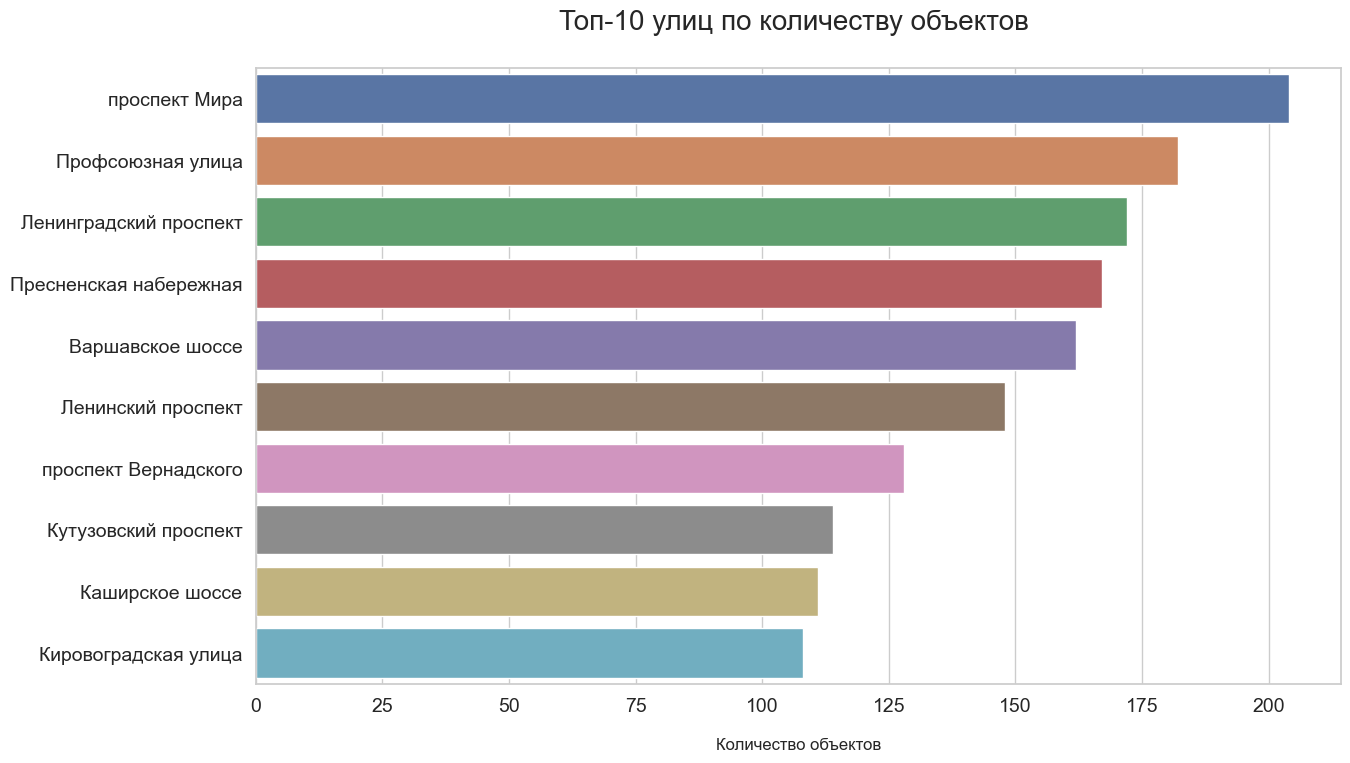

In [63]:
total = float(df.shape[0])
plt.figure(figsize=(14,8))
sns.set_palette('pastel')
sns.set_theme(style="whitegrid")
sns.barplot(x='count', y='street_name', orient = 'h', data=top10streets.reset_index())
plt.title('Топ-10 улиц по количеству объектов \n',fontsize=20)
plt.ylabel('')
plt.yticks(fontsize=14)
plt.xlabel('\nКоличество объектов')
plt.xticks(fontsize=14)
plt.show();

### Загрузка стороннего файла с улицами Москвы

In [64]:
mos_streets = pd.read_csv('data/mosgaz-streets.csv')

In [65]:
mos_streets.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


Применим функцию предобработки к датафрейму с улицами.

In [67]:
preprocess_text_columns(mos_streets)

Присоединим нашу табличку с улицами к топу 10 улиц.

In [69]:
top10streets_with_area = top10streets.merge(mos_streets[['streetname', 'area', 'okrug']],left_on='street_name',right_on='streetname',how='left')
top10streets_with_area

,count,streetname,area,okrug
0,204,проспект Мира,Алексеевский район,СВАО
1,204,проспект Мира,Ярославский Район,СВАО
2,204,проспект Мира,Район Марьина роща,СВАО
3,204,проспект Мира,Останкинский район,СВАО
4,204,проспект Мира,Район Ростокино,СВАО
5,204,проспект Мира,Район Свиблово,СВАО
6,204,проспект Мира,Мещанский район,ЦАО
7,182,Профсоюзная улица,Академический район,ЮЗАО
8,182,Профсоюзная улица,Район Черемушки,ЮЗАО
9,182,Профсоюзная улица,Район Ясенево,ЮЗАО


Посмотрим на список районов Москвы, через которые проходят эти улицы

In [70]:
top10streets_with_area['area'].value_counts()

Район Чертаново Центральное        2
Район Гагаринский                  2
Донской район                      2
Район Нагатино-Садовники           2
Район Проспект Вернадского         2
Район Теплый Стан                  2
Обручевский район                  2
Район Чертаново Южное              2
Район Тропарево-Никулино           2
Ломоносовский район                2
Район Чертаново Северное           2
Район Якиманка                     1
Район Раменки                      1
Район Дорогомилово                 1
Район Фили-Давыдково               1
Район Южное Бутово                 1
Район Северное Бутово              1
Нагорный район                     1
Район Москворечье-Сабурово         1
Район Орехово-Борисово Южное       1
Алексеевский район                 1
Ярославский Район                  1
Пресненский район                  1
Район Сокол                        1
Хорошевский район                  1
Район Беговой                      1
Район Аэропорт                     1
Р

Посмотрим на округа, через которые проходят эти улицы.

In [71]:
top10streets_with_area['okrug'].value_counts()

ЮЗАО    14
ЮАО     14
ЗАО      7
СВАО     6
САО      4
ЦАО      3
Name: okrug, dtype: int64

### Вывод

Больше всего объектов общественного питания находятся на улицах:

* Проспект Мира, 
* Профсоюзная улица (это самая протяженная улица в "спальном квартале" Москвы, с большим количеством жилых домов, средств инфраструктуры)
* Ленинградский проспект.

Большинство улиц с большим количеством объектов общественного питания в основном проходят через районы округов ЮЗАО и ЮАО. 

В ЦАО только 3 улицы, а в районах ВАО таких улиц с большим количеством объектов общепита вообще не обнаружено в этих данных.  

## Число улиц с одним объектом общественного питания. Районы Москвы, в которых находятся эти улицы

In [72]:
streets_wth_one_ob = df.groupby('street_name')['id'].agg({'count'}).query('count==1').reset_index()
print('Число улиц с одним объектом общественного питания: ', len(streets_wth_one_ob))

Число улиц с одним объектом общественного питания:  574


In [73]:
streets_wth_one_ob.head()

,street_name,count
0,1-й Балтийский переулок,1
1,1-й Басманный переулок,1
2,1-й Ботанический проезд,1
3,1-й Вешняковский проезд,1
4,1-й Голутвинский переулок,1


Объединим датафрейм с улицами, где 1 объект, с датафреймом с районами.

In [75]:
streets_wth_one_ob_area = streets_wth_one_ob.merge(mos_streets[['streetname', 'area']], 
                                             left_on='street_name', right_on='streetname', how='left')

In [76]:
streets_wth_one_ob_area.head()

,street_name,count,streetname,area
0,1-й Балтийский переулок,1,1-й Балтийский переулок,Район Аэропорт
1,1-й Басманный переулок,1,1-й Басманный переулок,Басманный район
2,1-й Басманный переулок,1,1-й Басманный переулок,Красносельский район
3,1-й Ботанический проезд,1,1-й Ботанический проезд,Район Свиблово
4,1-й Вешняковский проезд,1,1-й Вешняковский проезд,Рязанский район


Проверим количество строк в получившемся датафрейме.

In [77]:
len_orig = len(streets_wth_one_ob_area)
len_orig

620

In [80]:
f"Количество дубликатов: {streets_wth_one_ob_area.duplicated().sum()}"

'Количество дубликатов: 0'

Глянем, нет ли у нас пропусков.

In [85]:
print("Количество пропусков: \n", streets_wth_one_ob_area.isna().sum())

Количество пропусков: 
 street_name     0
count           0
streetname     53
area           53
dtype: int64


У нас 53 пропусков, то есть какие-то улицы из нашего датафрейма не сопоставились с улицами из датафрейма с районами. Посмотрим, что это за улицы.

In [87]:
streets_not_matched = []
for street in streets_wth_one_ob['street_name'].tolist():
    if street not in mos_streets['streetname'].tolist():
        streets_not_matched.append(street)

In [83]:
streets_not_matched

['1-й Заречный переулок',
 '1-я Ватутинская улица',
 '104-й километр Московской Кольцевой Автодороги',
 '2-я Барышевская улица',
 '26-й километр Московской Кольцевой Автодороги',
 '3-я Подрезковская улица',
 '30-й километр Московской Кольцевой Автодороги',
 '31-й километр Московской Кольцевой Автодороги',
 '34-й километр Московской Кольцевой Автодороги',
 '38-й километр Московской Кольцевой Автодороги',
 '39-й километр Калужского шоссе',
 '42-й километр Московской Кольцевой Автодороги',
 '43-й километр МКАД',
 '44-й километр',
 '56-й километр Московской Кольцевой Автодороги',
 '65-й километр Московской Кольцевой Автодороги',
 '67-й километр Московской Кольцевой Автодороги',
 '78-й километр Московской Кольцевой Автодороги',
 '80-й километр Московской Кольцевой Автодороги',
 'Армейская улица',
 'Большая Октябрьская улица',
 'Институтский проезд',
 'Новобутовский проезд',
 'Троицкий бульвар',
 'Физическая улица',
 'Фитаревская улица',
 'Цветочная улица',
 'квартал № 30',
 'квартал № 80',


In [88]:
len(streets_not_matched)

53

Все сходится. 53 улиц не обнаружили себе дубликата в датафрейме с районами.

Похоже, это большинство локаций из городов-поселений за МКАДом, из округов Новой Москвы и подобных. Проверим это.

Сделаем срез по имени улицы, проверяя, что оно содержится в списке @streets_not_matched.

In [89]:
streets_not_matched_df = df.query('street_name in @streets_not_matched')
streets_not_matched_df

,id,object_name,chain,object_type,address,number,chain_name,street_name
1857,151292,Ред-Кафе,нет,кафе,"город Москва, поселение Новофедоровское, дерев...",45,unknown,улица Рассудовское Лесничество
1860,77869,Кафе «Наш бараш»,нет,ресторан,"город Москва, поселение Десеновское, Армейская...",60,unknown,Армейская улица
1864,77766,Обухов Паб,нет,ресторан,"город Москва, поселение Московский, квартал № ...",80,unknown,квартал № 80
1866,79996,Подмосковные вечера,нет,ресторан,"город Москва, город Щербинка, 2-я Барышевская ...",72,unknown,2-я Барышевская улица
1896,137317,ООО Кобинат питания КОНКОРД,нет,столовая,"город Москва, поселение Кленовское, село Клено...",100,unknown,улица 1-й километр Объездной Дороги
2997,83284,Кафе «Восточная сказка»,нет,кафе,"город Москва, 3-я Подрезковская улица, дом 14,...",60,unknown,3-я Подрезковская улица
3713,23514,ОСИПОВ А.С. (прод.база «Очаково»),нет,столовая,"город Москва, проектируемый проезд № 1980, дом 4",60,unknown,проектируемый проезд № 1980
5554,23249,Метро К&К,да,кафе,"город Москва, 104-й километр Московской Кольце...",80,unknown,104-й километр Московской Кольцевой Автодороги
5908,28327,Саят Нова,нет,ресторан,"город Москва, улица Капотня, дом 34",220,unknown,улица Капотня
6021,23969,АРТИКО,нет,кафе,"город Москва, 38-й километр Московской Кольцев...",94,unknown,38-й километр Московской Кольцевой Автодороги


In [90]:
streets_not_matched_df[~streets_not_matched_df['address'].str.contains(r'(Москва,? город)|поселение|деревня|километр', regex=True)]

,id,object_name,chain,object_type,address,number,chain_name,street_name
2997,83284,Кафе «Восточная сказка»,нет,кафе,"город Москва, 3-я Подрезковская улица, дом 14,...",60,unknown,3-я Подрезковская улица
3713,23514,ОСИПОВ А.С. (прод.база «Очаково»),нет,столовая,"город Москва, проектируемый проезд № 1980, дом 4",60,unknown,проектируемый проезд № 1980
5908,28327,Саят Нова,нет,ресторан,"город Москва, улица Капотня, дом 34",220,unknown,улица Капотня
6239,98910,Subway,да,предприятие быстрого обслуживания,"город Москва, Новобутовский проезд, владение 9...",12,Subway,Новобутовский проезд
8025,28195,БИЗНЕС ЦЕНТР ТАГАНСКИЙ,нет,кафе,"город Москва, улица Высоцкого, дом 4",80,unknown,улица Высоцкого
10599,183874,Японоитальяна,нет,закусочная,"город Москва, улица Недорубова, дом 5",4,unknown,улица Недорубова
12182,192097,Ветерок,нет,кафе,"город Москва, улица Старые Кузьминки, дом 10",40,unknown,улица Старые Кузьминки
13747,213415,Тандыр,нет,магазин (отдел кулинарии),"город Москва, улица Льва Яшина, дом 5, корпус 1",0,unknown,улица Льва Яшина


Улица Высоцкого - это бывшие Нижний Таганский тупик, Верхний Таганский тупик. Это Таганский район. Текущий файл улиц Мосгаза неактуальный. И улица Старые Кузьминки - Кузьминский район. Поправлю это точечно. Все остальное - за МКАДом. Пометим такие строки в столбце area как "район не определен".

In [91]:
streets_wth_one_ob_area.loc[streets_wth_one_ob_area['street_name']=='улица Высоцкого', 'area'] = 'Таганский район'

In [92]:
streets_wth_one_ob_area.loc[streets_wth_one_ob_area['street_name']=='улица Старые Кузьминки', 'area'] = 'район Кузьминки'

Проверим, что получилось.

In [93]:
streets_wth_one_ob_area[streets_wth_one_ob_area.street_name.isin(['улица Высоцкого', 'улица Старые Кузьминки'])]

,street_name,count,streetname,area
533,улица Высоцкого,1,NaN,Таганский район
606,улица Старые Кузьминки,1,NaN,район Кузьминки


Заполняем оcтальные пропуски в area значением "не определен".

In [94]:
streets_wth_one_ob_area['area'] = streets_wth_one_ob_area['area'].fillna('не определен')

In [95]:
print("Количество пропусков:\n", streets_wth_one_ob_area.isna().sum())

Количество пропусков:
 street_name     0
count           0
streetname     53
area            0
dtype: int64


Проверим, что количество строк осталось таким же

In [96]:
len_orig == len(streets_wth_one_ob_area)

True

In [97]:
streets_wth_one_ob_area.head()

,street_name,count,streetname,area
0,1-й Балтийский переулок,1,1-й Балтийский переулок,Район Аэропорт
1,1-й Басманный переулок,1,1-й Басманный переулок,Басманный район
2,1-й Басманный переулок,1,1-й Басманный переулок,Красносельский район
3,1-й Ботанический проезд,1,1-й Ботанический проезд,Район Свиблово
4,1-й Вешняковский проезд,1,1-й Вешняковский проезд,Рязанский район


Уберем лишний столбец streetname.

In [98]:
streets_wth_one_ob_area = streets_wth_one_ob_area[['street_name', 'count', 'area']]
streets_wth_one_ob_area.head()

,street_name,count,area
0,1-й Балтийский переулок,1,Район Аэропорт
1,1-й Басманный переулок,1,Басманный район
2,1-й Басманный переулок,1,Красносельский район
3,1-й Ботанический проезд,1,Район Свиблово
4,1-й Вешняковский проезд,1,Рязанский район


In [103]:
f"Количество улиц, где расположен только 1 объект общественного питания: {len(streets_wth_one_ob_area)}"

'Количество улиц, где расположен только 1 объект общественного питания: 620'

Сделаем еще одну группировку данных: определим районы, где больше всего улиц с 1 объектом общественного питания.
В сгруппированных данных переименуем столбец count  в count_of_one_object_streets.

In [99]:
areas_wth_one_ob_street = (streets_wth_one_ob_area.pivot_table(index=['area'], columns='count', 
                                     values='street_name', aggfunc='count').reset_index())
areas_wth_one_ob_street.columns = ['area', 'count_of_one_object_streets']
areas_wth_one_ob_street.head()

,area,count_of_one_object_streets
0,Алексеевский район,7
1,Алтуфьевский район,1
2,Бабушкинский район,4
3,Басманный район,25
4,Бескудниковский Район,2


In [100]:
(areas_wth_one_ob_street
 .sort_values(by='count_of_one_object_streets', ascending=False)
 .style
 .format("{}")
 .background_gradient(cmap='Blues', axis=0)
)

,area,count_of_one_object_streets
100,не определен,51
94,Таганский район,28
80,Район Хамовники,26
3,Басманный район,25
95,Тверской район,20
21,Пресненский район,20
51,Район Марьина роща,18
22,Район Арбат,18
13,Мещанский район,16
74,Район Сокольники,15


### Вывод

* У нас 574 улиц имеют 1 объект общественного питания. 

* Список этих улиц можно получить из датафрейма streets_wth_one_ob.

* 53 улицы находится за МКАДом, районы Новой Москвы и подобного. Мы не определяли точные районы для них. В любом случае это будет несколько локаций, а не одна.

* Больше всего улиц с 1 объектом в черте МКАД находится в следующих районах Москвы: Таганский, Хамовники, Басманный.

## Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить

Отфильтруем данные только для топ-10 улиц с большим количеством объектов общественного питания.

In [104]:
top10streets = top10streets.reset_index()
for_top10 = df[df['street_name'].isin(top10streets['street_name'].tolist())]
for_top10.head()

,id,object_name,chain,object_type,address,number,chain_name,street_name
151,155973,Кафе «Андерсон»,да,кафе,"город Москва, Варшавское шоссе, дом 2",150,кафе АндерСон,Варшавское шоссе
152,23618,Кафе «Subway»,да,кафе,"город Москва, Варшавское шоссе, дом 7, корпус 1",36,Subway,Варшавское шоссе
153,155852,Кафе «Ламаджо»,нет,кафе,"город Москва, Варшавское шоссе, дом 29",30,unknown,Варшавское шоссе
154,152556,Шаурма в пите,нет,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0,unknown,Варшавское шоссе
155,120658,Выпечка,нет,кафетерий,"город Москва, Варшавское шоссе, дом 100",2,unknown,Варшавское шоссе


Посмотрим на описательную статистику для числа посадочных мест для топ-10 улиц с большим количеством заведений.

In [105]:
for_top10['number'].describe()

count    1496.000000
mean       58.232620
std        90.213048
min         0.000000
25%        12.000000
50%        40.000000
75%        75.000000
max      1700.000000
Name: number, dtype: float64

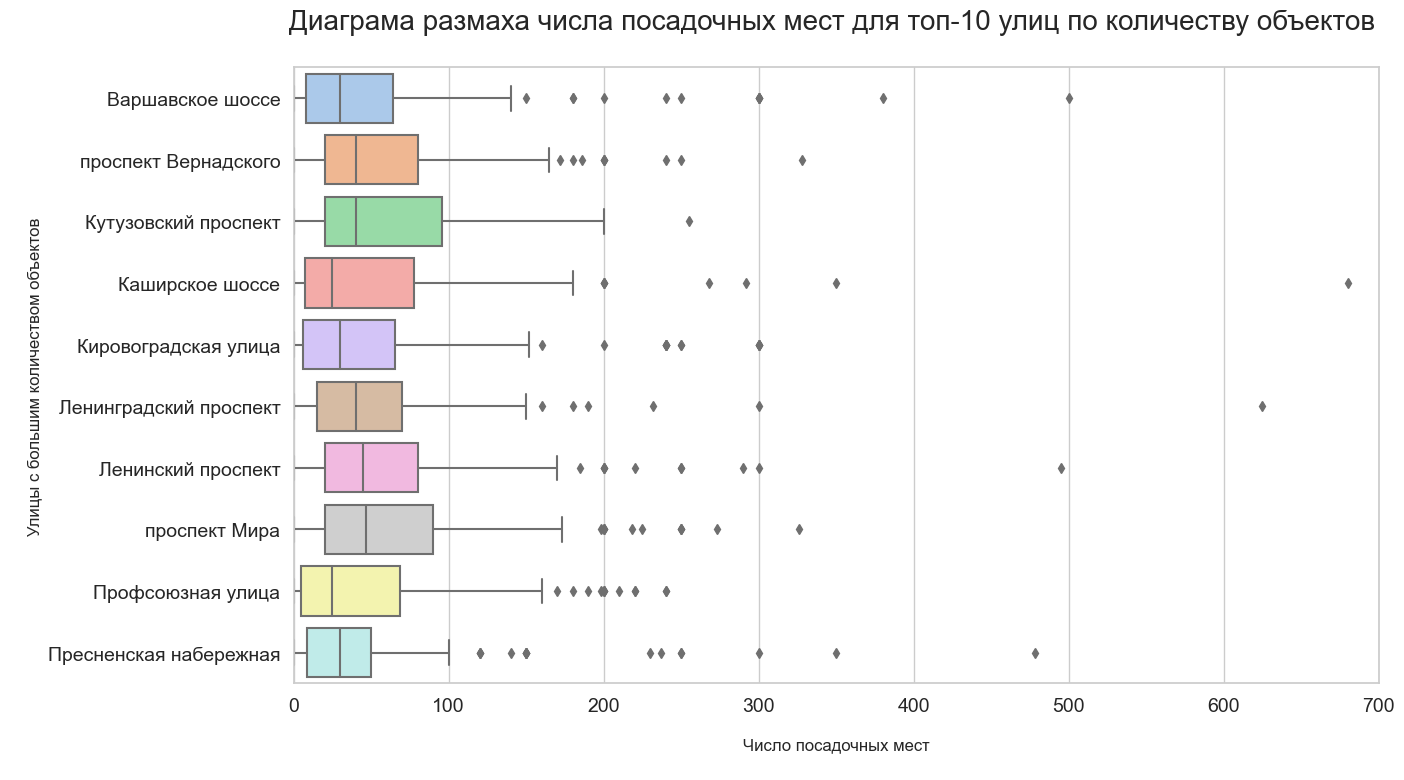

In [106]:
plt.figure(figsize=(14,8))
sns.set_palette('pastel')
sns.boxplot(x="number", y="street_name", data=for_top10, orient='h')
plt.xlim(0,700)
#plt.xticks(rotation=60)
plt.title('Диаграма размаха числа посадочных мест для топ-10 улиц по количеству объектов \n',fontsize=20)
plt.xlabel('\nЧисло посадочных мест\n')
plt.yticks(fontsize=14)
plt.ylabel('\nУлицы с большим количеством объектов')
plt.xticks(fontsize=14)
plt.show();

In [107]:
for_top10[for_top10['street_name']=='Пресненская набережная']['number'].describe()

count    167.000000
mean      45.844311
std       65.316834
min        0.000000
25%        8.500000
50%       30.000000
75%       50.000000
max      478.000000
Name: number, dtype: float64

In [108]:
for_top10[for_top10['street_name']=='Кутузовский проспект']['number'].describe()

count     114.000000
mean       85.061404
std       194.464196
min         0.000000
25%        20.000000
50%        40.000000
75%        96.000000
max      1700.000000
Name: number, dtype: float64

Посмотрим также на размах значений посадочных мест для всех остальных улиц. 

In [109]:
top10 = for_top10["street_name"].tolist()
df.query('street_name not in @top10')['number'].describe()

count    13788.000000
mean        59.952713
std         72.977933
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1500.000000
Name: number, dtype: float64

Большой разницы не наблюдается.

### Вывод

* Выделяются Пресненская набережная и Кутузовский проспект. 

* Пресненская набережная проходит только через ЦАО и имеет маленькую протяженность. Здесь межквартильный размах значений уже всего, в среднем количество посадочных мест меньше в сравнении с остальными улицами. Возможно, для объектов центральных райнов Москвы характерно в среднем маленькое количество посадочных мест. Но для этого все же нужно изучить пристально другие объекты в ЦАО с точки зрения посадочных мест. Тут же у нас только один район из ЦАО. 
    
* Кутузовский проспект, наоборот, выделяется среди топ-10 наибольшим межквартильным размахом, 75% объектов имеют 96 посадочных мест.

<a name='stage_3'></a>
# Шаг 3. Общий вывод, рекомендации
[Назад к оглавлению](#contents)

* Мы проанализировали 15 284 записей о 15 284 объектах общественного питания, включая объекты новых округов Москвы за МКАДом.  

* В Москве чаще всего представлены кафе, столовые и рестораны.

* Сетевые объекты составляют примерно 20% от всех данных. 80% объектов не являются сетевыми. 

* Сетевое распространение характерно для предприятий быстрого обслуживания, магазинов (отделов кулинарии), ресторанов и кафе.

* Для большей части сетей характерно малое количество заведений с большим количеством посадочных мест.

* Среднее количество посадочных мест для столовых (103), ресторанов (80), баров(35), буфетов (32), кафе (30).

* Большая часть улиц с наибольшим количеством объектов находится в районах ЮЗАО и ЮАО. 

Полный список таких улиц ниже в порядке убывания по количеству объектов общепита:

    проспект Мира
    
    Профсоюзная улица
    
    Ленинградский проспект
    
    Пресненская набережная
    
    Варшавское шоссе
    
    Ленинский проспект
    
    проспект Вернадского
    
    Кутузовский проспект
    
    Каширское шоссе
    
    Кировоградская улица
    
* 574 улицы имеют только 1 объект общественного питания. 
Большинство таких улиц находится в районах центрального округа (Хамовники, Басманный, Тверской, Пресненский, Арбат)
    
* Для улиц в центральном районе, скорее всего, число посадочных мест в среднем будет значительно меньше.


##  Рекомендации

У нас очень мало информации от инвесторов и учредителей. Мы только знаем о желании "открыть небольшое кафе в Москве, которое оригинальное — гостей должны обслуживать роботы и что проект дорогой.

Дать целевые рекомендации поэтому трудно. Однако попробуем исходить из того, что мы знаем.

* Кафе - это самый популярный вид общественного питания в Москве по данным этого исследования (составляет 39.7% от всех данных), поэтому можно сказать, что учредители выбрали успешный вид объекта.

* Кроме того, для кафе как раз характерно небольшое число посадочных мест в сравнении с другими объектами (в среднем 30 посадочных мест). Это как раз вписывается в формат "небольшого" кафе. 

* Если речь идет о небольшом кафе, то в качестве локаций для него можно рассмотреть центральные районы Москвы. Там находится наибольшее число улиц, где только 1 объект общественного питания, а значит, будет меньше конкурентов, и при этом там, похоже, локализуются именно небольшие кафе. 

* Для кафе характерно сетевое распространение по данным нашего исследования. Если первое кафе будет успешным, можно будет масштабировать бизнес и увеличить прибыль.

## Доступ к презентации

[Ссылка на презентацию](https://docs.google.com/presentation/d/1S6zuvuKHGLd9cyKFZ7VBelAG7rZNrkI1fsxYJyjtDY4/edit?usp=sharing)